In [1]:
# If you'd like to use GPU, please uncomment the following lines
# %set_env CUDA_VISIBLE_DEVICES=0
# %load_ext cudf.pandas
import pandas as pd
from unibench.benchmarks_zoo.registry import list_benchmarks
from unibench.models_zoo.registry import list_models
from unibench.output import OutputHandler
import seaborn as sns
import matplotlib.pyplot as plt
from unibench.common_utils.utils import get_model_mappings, get_benchmark_mappings

models = [
    "openclip_vitB32_400m",
    "openclip_vitL14_400m",
    "eva01_vitG14_400m",
    "openclip_vitB32_2b",
    "openclip_vitB32_datacomp_s",
    "openclip_vitB32_datacomp_m",
    "openclip_vitB32_datacomp_xl",
    "openclip_vitB32_metaclip_fullcc",
    "openclip_vitB32_metaclip_400m",
]
datasets = ["mnist"]
outputhandler = OutputHandler(output_dir="/fsx-robust/haideraltahan/outputs")

params = ["dataset_size", "model_size"]
models_params = [
    [
        "openclip_vitB32_2b",
        "openclip_vitB32_datacomp_s",
        "openclip_vitB32_datacomp_m",
        "openclip_vitB32_datacomp_xl",
        "openclip_vitB32_metaclip_fullcc",
        "openclip_vitB32_metaclip_400m",
    ],
    [
        "openclip_vitB32_400m",
        "openclip_vitL14_400m",
        "eva01_vitG14_400m",
    ],
]

xlabels = ["Training Dataset Size (Million)", "Model Size (Million)"]

/data/home/haideraltahan/anaconda3/envs/clip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
outputhandler.load_all_csv(
    model_name=models,
    benchmark_name=datasets,
)
results = outputhandler.query(**{"benchmark_name": datasets, "model_name": models})

In [9]:
for param in params:
    model_mappings = get_model_mappings(param)
    results[param] = results["model_name"].map(model_mappings)

In [10]:
dataset_mappings = get_benchmark_mappings("benchmark_type")
results["benchmark_type"] = results["benchmark_name"].map(dataset_mappings)

vg_relation = results[results.benchmark_name == "vg_relation"]
vg_relation = (
    vg_relation.groupby(["model_name", "benchmark_name", "benchmark_type"] + params)[
        "correctness"
    ]
    .mean()
    .reset_index()
)

vg_relation.split = ""

vg_attribution = results[results.benchmark_name == "vg_attribution"]
vg_attribution.loc[:, "attribute"] = [",".join(l) for l in vg_attribution["attribute"]]
cond = vg_attribution.groupby(["model_name", "attribute"])["attribute"].count() >= 25

vg_attribution = vg_attribution.groupby(
    ["model_name", "benchmark_name", "benchmark_type", "attribute"] + params
)["correctness"].mean()
vg_attribution = vg_attribution[cond.values].reset_index()
vg_attribution.split = ""

results.drop(results[results.benchmark_name == "vg_relation"].index, inplace=True)
results.drop(results[results.benchmark_name == "vg_attribution"].index, inplace=True)
results = pd.concat([results, vg_relation, vg_attribution])

dataset_mappings = get_benchmark_mappings("benchmark_type")
results["benchmark_type"] = results["benchmark_name"].map(dataset_mappings)

KeyError: 'attribute'

In [ ]:
results = pd.read_pickle("df_mean.pkl").reset_index()
for param in params:
    model_mappings = get_model_mappings(param)
    results[param] = results["model_name"].map(model_mappings)

dataset_mappings = get_benchmark_mappings("dataset_type")
results["dataset_type"] = results["dataset_name"].map(dataset_mappings)

In [11]:
df_mean = (
    results.groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["benchmark_type", "model_name"] + params)
    .correctness.median()
)
df_sem = (
    results.groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["model_name", "benchmark_name", "benchmark_type"] + params)
    .correctness.mean()
    .reset_index()
    .groupby(["benchmark_type", "model_name"] + params)
    .correctness.sem()
)

dataset_types = list(df_mean.reset_index().benchmark_type.unique())

0it [00:00, ?it/s]

2it [00:00, 10.16it/s]


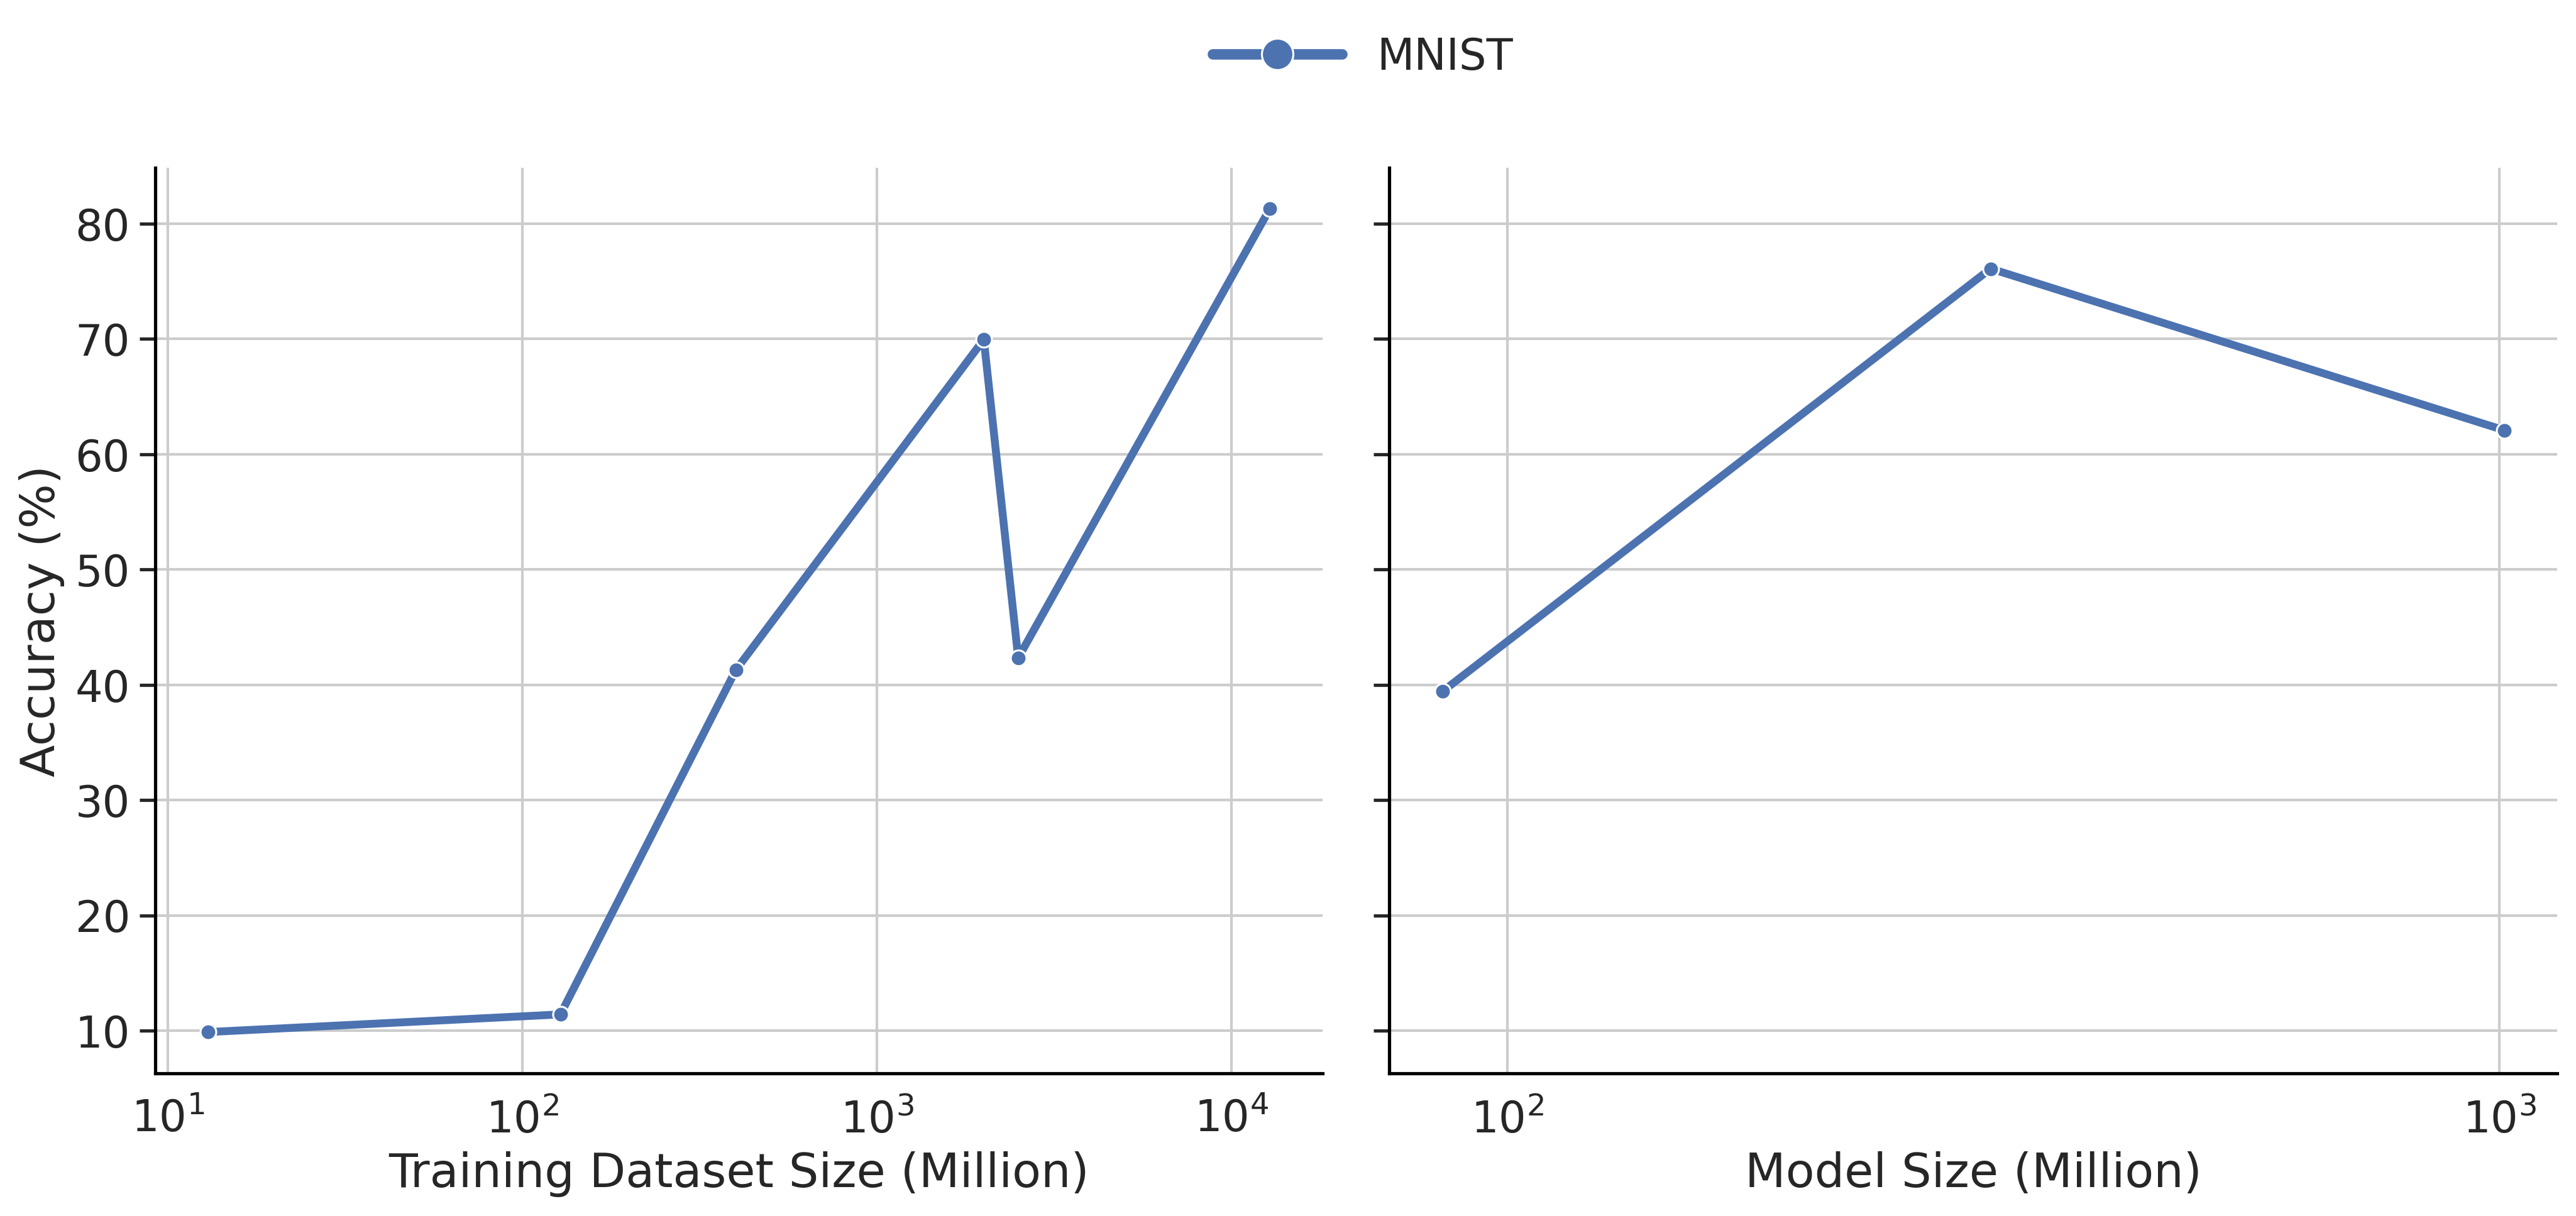

In [16]:
from tqdm import tqdm

sns.set(font_scale=1.5)
sns.set_style(
    "whitegrid",
    rc={"ytick.left": True, "axes.grid": True},
)
fig, axs = plt.subplots(
    1,
    len(params),
    sharey=True,
    figsize=(14, 6),
    dpi=300,
)
for i, (param, ax) in tqdm(enumerate(zip(params, list(axs.flat)))):

    df_m = (
        df_mean.reset_index()[df_mean.reset_index().model_name.isin(models_params[i])]
        .groupby(["benchmark_type"] + [param])
        .correctness.median()
        .reset_index()
    )
    df_m.correctness = df_m.correctness * 100
    df_s = (
        df_sem.reset_index()[df_sem.reset_index().model_name.isin(models_params[i])]
        .groupby(["benchmark_type"] + [param])
        .correctness.sem()
        .reset_index()
    )
    df_s.correctness = df_s.correctness * 100

    ax = sns.lineplot(
        data=df_m.reset_index(),
        x=param,
        y="correctness",
        hue="benchmark_type",
        ax=ax,
        legend=i == 0,
        marker="o",
        linewidth=3,
    )

    if i == 0:
        h, l = ax.get_legend_handles_labels()
        ax.legend_.remove()
    ax.set(xscale="log")

    ax.set_xlabel(xlabels[i])
    ax.set_ylabel("Accuracy (%)")
    sns.despine(ax=ax)
    for _, s in ax.spines.items():
        s.set_color("black")

leg = fig.legend(
    h,
    ["MNIST" for label in l],
    loc="lower right",
    bbox_to_anchor=(0.6, 1),
    ncol=4,
    frameon=False,
    markerscale=2,
    handlelength=3,
)
plt.setp(leg.get_lines(), linewidth=4)

plt.tight_layout()
# plt.savefig("pngs/results_summary_dataset_.png", dpi=300, bbox_inches="tight")

In [ ]:
df_big.sort_values(by=["model_name", "dataset_name"])

,dataset_name,model_name,correctness
18,caltech101,eva01_vitG14_400m,0.167160
78,cars,eva01_vitG14_400m,0.916801
138,cifar10,eva01_vitG14_400m,0.982900
198,cifar100,eva01_vitG14_400m,0.887600
258,clevr_count,eva01_vitG14_400m,0.195067
318,clevr_distance,eva01_vitG14_400m,0.170800
378,country211,eva01_vitG14_400m,0.286114
438,cub,eva01_vitG14_400m,0.737832
498,dmlab,eva01_vitG14_400m,0.181174
558,dollar_street,eva01_vitG14_400m,0.529944
